<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/EBM_Ex_9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.metrics import r2_score

df=pd.read_excel('Exercício 9.1.xlsx', sheet_name="Historico")
dataset_cols = ["Date", "Press", "Np", "Rp", "Wp", "Winj", "Bt", "Bg"]
df.columns = dataset_cols
# df=pd.read_excel('unisim_hist.xlsx').iloc[:, :-5]
df.head()

,Date,Press,Np,Rp,Wp,Winj,Bt,Bg
0,1943-10-07,144.48,0.000,0.00,0.0,0.0,1.5166,1.2217
1,1945-04-30,138.08,219.879,172.76,0.0,0.0,1.5451,1.2835
2,1945-09-30,135.27,331.806,172.94,0.0,0.0,1.5623,1.3130
3,1946-02-28,133.37,454.863,172.05,0.0,0.0,1.5730,1.3337
4,1946-05-31,132.11,540.557,170.98,0.0,0.0,1.5808,1.3480


In [ ]:
## Parametros escalares
re = 1417
phi = 0.25
k = 500
m = 0.0731
N = 3.673E6
Rsi = 160.3
Bw = 1
uw = 1

In [ ]:
df["t"] = (df["Date"]-df["Date"].iloc[0]).astype("int64")/10**9/60/60/24
df["dt"]=df["t"].diff().fillna(0)
df["dp"]= df["Press"].iloc[0]-df["Press"]
df["p_med"]= (df["Press"]+(df["Press"]-df["Press"].diff()).fillna(df["Press"].iloc[0]))/2
df["pmt"]=((df["Press"].iloc[0]-df["p_med"])*df["dt"]).cumsum()
df.head()

,Date,Press,Np,Rp,Wp,Winj,Bt,Bg,t,dt,dp,p_med,pmt
0,1943-10-07,144.48,0.000,0.00,0.0,0.0,1.5166,1.2217,0.0,0.0,0.00,144.480,0.000
1,1945-04-30,138.08,219.879,172.76,0.0,0.0,1.5451,1.2835,571.0,571.0,6.40,141.280,1827.200
2,1945-09-30,135.27,331.806,172.94,0.0,0.0,1.5623,1.3130,724.0,153.0,9.21,136.675,3021.365
3,1946-02-28,133.37,454.863,172.05,0.0,0.0,1.5730,1.3337,875.0,151.0,11.11,134.320,4555.525
4,1946-05-31,132.11,540.557,170.98,0.0,0.0,1.5808,1.3480,967.0,92.0,12.37,132.740,5635.605


In [ ]:
df["F"] = df["Np"]*1000*(df["Bt"]+(df["Rp"]-Rsi)*df["Bg"]/1000)+(df["Wp"]-df["Winj"])*Bw*1000
df["Eo"] = df["Bt"]-df["Bt"].iloc[0]
df["Eg"] = df["Bt"].iloc[0]*(df["Bg"]/df["Bg"].iloc[0]-1)

df.head()

,Date,Press,Np,Rp,Wp,Winj,Bt,Bg,t,dt,dp,p_med,pmt,F,Eo,Eg
0,1943-10-07,144.48,0.000,0.00,0.0,0.0,1.5166,1.2217,0.0,0.0,0.00,144.480,0.000,0.000000,0.0000,0.000000
1,1945-04-30,138.08,219.879,172.76,0.0,0.0,1.5451,1.2835,571.0,571.0,6.40,141.280,1827.200,343251.438018,0.0285,0.076718
2,1945-09-30,135.27,331.806,172.94,0.0,0.0,1.5623,1.3130,724.0,153.0,9.21,136.675,3021.365,523887.272354,0.0457,0.113338
3,1946-02-28,133.37,454.863,172.05,0.0,0.0,1.5730,1.3337,875.0,151.0,11.11,134.320,4555.525,722627.645701,0.0564,0.139035
4,1946-05-31,132.11,540.557,170.98,0.0,0.0,1.5808,1.3480,967.0,92.0,12.37,132.740,5635.605,862294.710128,0.0642,0.156787


In [ ]:
train = df.copy()

p=train["Press"].values
dp=train["dp"].values
t=train["t"].values
dt=train["dt"].values
F=train["F"].values
Eo=train["Eo"].values
Eg=train["Eg"].values
npp=train["Np"].values
rp=train["Rp"].values
wp=train["Wp"].values
winj=train["Winj"].values
pmt=train["pmt"].values
p_med=train["p_med"].values

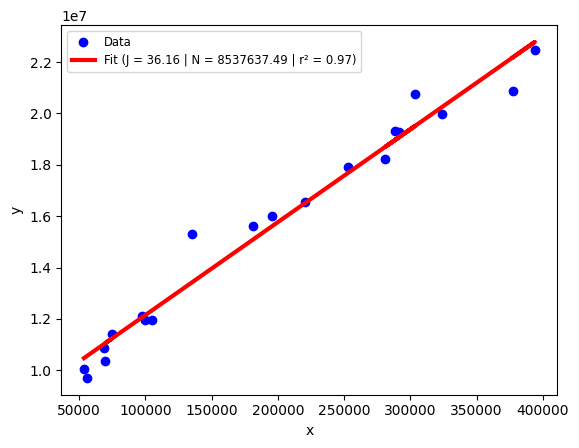

In [ ]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We
## We = (F-N*(Eo+mEg+(1+m)Efw)
## Neste caso, Efw = 0, então
## F/Eo+mEg = N + We/(Eo+mEg)

## Schilthuis
## We = J∫(p_i-p).dt
## We = J.∑[p_i-p_j+1]*∆t
## We = J.pmt

## F/Eo+mEg = N + We/(Eo+mEg)
## y = ax + b
## y = F/Eo+mEg
## a = J
## b = N
## x = pmt/(Eo+mEg)

y = F[1:]/(Eo+m*Eg)[1:]
x = pmt[1:]/(Eo+m*Eg)[1:]
# x, y
a, b = np.polyfit(x, y, 1)
r2 = r2_score(y, a*x+b)
plt.scatter(x, y, label="Data", color="blue")
plt.plot(x, a*x+b, label=f"Fit (J = {a:0.2f} | N = {b:0.2f} | r\N{SUPERSCRIPT TWO} = {r2:.2f})", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [ ]:
## EBM
## We = F-N*(Eo+mEg)
## F = N*(Eo+mEg)+We
## F/(Eo+mEg) = N + We/(Eo+mEg)
## y = ax + b
## y = F/Eo+mEg
## a = J
## b = N
## x = pmt/(Eo+mEg)


# Função objetivo
def objective(x, Eo, Eg, F, m):
    N = x[0]  # N é constante
    We = x[1:]  # We para cada ponto no tempo
    F_calc = N * (Eo + m * Eg) + We
    # print(np.sum((F - F_calc) ** 2))
    return np.sum((F - F_calc) ** 2)

# Chute inicial para N e We para cada t
x0 = np.array([1] + [0] * len(F))  # 1 para N e 1 para cada We(t)

# Limites para N e We(t), ambos maiores ou iguais a zero.
bounds = [(1, None)] + [(0, None) for _ in F]

# Restrições para garantir que We(t+1) >= We(t)
def constraint_We(We, i):
    return We[i + 1] - We[i]

constraints = []
for i in range(len(F) - 1):
    constraints.append({'type': 'ineq', 'fun': lambda x, i=i: constraint_We(x[1:], i)})

# Otimização com restrições
result = minimize(objective, x0, args=(Eo, Eg, F, m), bounds=bounds, constraints=constraints)
##, constraints=constraints

N_est = result.x[0]
We_est = result.x[1:]

print(f"Estimativa de N: {N_est}")
print(f"Estimativas de We: {We_est}")

Estimativa de N: 4576448.005889755
Estimativas de We: [8.38434187e-24 1.87157694e+05 2.76827542e+05 4.18003400e+05
 5.16035511e+05 5.38768231e+05 8.33487092e+05 8.76046187e+05
 9.53357774e+05 1.40844036e+06 1.56370553e+06 1.69118974e+06
 1.85639561e+06 2.08398813e+06 2.24891298e+06 2.32118149e+06
 2.36527777e+06 2.41982218e+06 2.57527367e+06 2.67856695e+06
 2.69457077e+06]


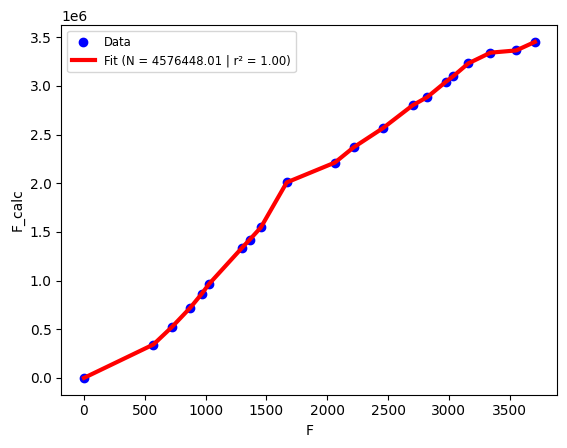

In [ ]:
F_calc = N_est * (Eo + m * Eg) + We_est
r2 = r2_score(F, F_calc)

plt.scatter(t, F, label="Data", color="blue")
plt.plot(t, F_calc, label=f"Fit (N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2:.2f})", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("F")
plt.ylabel("F_calc")
plt.show()

In [ ]:
## Schilthuis
## We = J∫(p_i-p).dt
## We = J.∑[p_i-p_j+1]*∆t
## p_j+1_ = [p_j+p_j+1]/2
## ∆t = t_j+1-t_j
## j = 0....n-1

#Aquífero Schilthuis
def we_pred1(t, J):
    dt=t-np.roll(t,1)
    p_med=(p+np.roll(p,1))/2
    pmt = ((p[0]-p_med[2:])*dt[2:]).cumsum()
    return np.append(np.zeros(2), J*pmt[0:len(t)])

# Chute inicial para J
initialGuess1=[0]

# Ajuste da curva
popt1,pcov1 = curve_fit(we_pred1, t, We_est, initialGuess1)

fittedData1 = we_pred1(t, *popt1)
r2_1 = r2_score(We_est, fittedData1)
print(popt1, r2_1)

[52.11323648] 0.9026282123732836


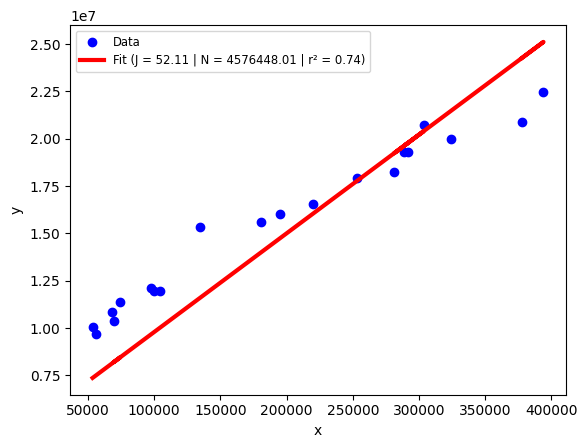

In [ ]:
y = F[1:]/(Eo+m*Eg)[1:]
x = pmt[1:]/(Eo+m*Eg)[1:]

y_pred = N_est + popt1[0]*x
r2 = r2_score(y, y_pred)
plt.scatter(x, y, label="Data", color="blue")
plt.plot(x, y_pred, label=f"Fit (J = {popt1[0]:0.2f} | N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2:.2f})", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

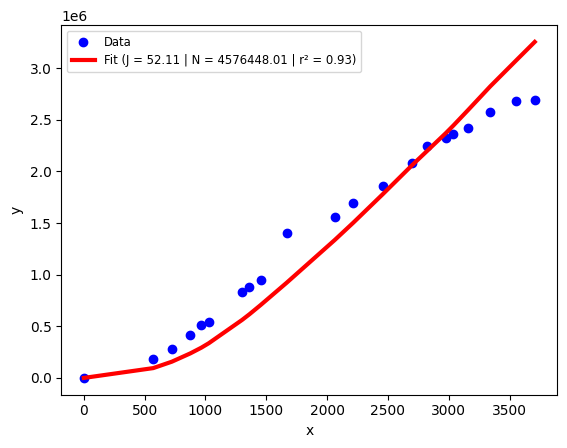

In [113]:
r2 = r2_score(We_est, popt1[0]*pmt)
plt.scatter(t, We_est, label="Data", color="blue")
plt.plot(t, popt1[0]*pmt, label=f"Fit (J = {popt1[0]:0.2f} | N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2:.2f})", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("x")
plt.ylabel("y")
plt.show()